In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import nibabel as nib
import pandas as pd
from torch.utils import data
import torchvision.models as models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from utils import *
from nilearn.image import resample_img 
from scipy.ndimage import zoom
from nilearn import plotting
import time
from sklearn.model_selection import KFold
import pickle
from skimage.metrics import structural_similarity 
from skimage.metrics import peak_signal_noise_ratio 
import pathlib

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_df(pth):
    l = []
    for i in os.listdir(pth):
        l.append(pth +i)
    df = pd.DataFrame(l)
    return df

data = [x for x in range(0,502)]
kfold = KFold(5)
fold_id =[]
for train, test in kfold.split(data):
    fold_id.append([train,test])
    
    
def get_test(data, f):
    l = []
    for i in os.listdir("All_maps/" + data +"/"):
        id_ = int(i.split("_")[0][3:])
        if id_ in fold_id[f][1]:
            l.append("All_maps/" + data +"/" +i)
    df = pd.DataFrame(l)
    return df

def get_train(data, f):
    l = []
    for i in os.listdir("All_maps/" + data +"/"):
        id_ = int(i.split("_")[0][3:])
        if id_ in fold_id[f][0]:
            l.append("All_maps/" + data +"/" +i)
    df = pd.DataFrame(l)
    return df

class DatasetFromNii(Dataset):    
    def __init__(self, df):
        self.to_tensor = transforms.ToTensor()
        self.data_info = df
        self.a = np.asarray(self.data_info.iloc[:, 0])
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # read single nii
        aa = np.load(self.a[index]).astype(np.float32) 
        img_as_tensor = torch.from_numpy(aa)
        return img_as_tensor

    def __len__(self):
        return self.data_len

In [6]:
### get ReconstrMSE for model
def get_model(model_name):
    if model_name == "AE3":
        model = AE(3)
    elif model_name == "AE9":
        model = AE(9)
    elif model_name == "AE18":
        model = AE(18)
    elif model_name == "AElin64":
        model = AElin(64)
    elif model_name == "AElin128":
        model = AElin(128)
    elif model_name == "AElin256":
        model = AElin(256)
    elif model_name == "AEup3":
        model = AEup(3)
    elif model_name == "AEup9":
        model = AEup(9)
    elif model_name == "AEup18":
        model = AEup(18)
    elif model_name == "AEconc3":
        model = AEconc(3)
    return model

def get_mse(df, model_pth):
#     print("#",model_name,len(df))
    model = get_model(model_name) 
    model.load_state_dict(torch.load(model_pth,map_location="cuda"))
    model.eval()
    
    all_mse = 0
    all_psnr = 0
    all_ssim = 0
    for i, r in df.iterrows():
        a = np.load(r[0])
        aa = torch.from_numpy(np.expand_dims(a,axis = 0).astype(np.float32))
        out, encode = model(aa)
        out = out[0,:,:,:,:].detach().cpu().numpy()
        af = a.flatten()
        bf = out.flatten()
        mse = ((af - bf)**2).mean(axis=0)
        
        max_value = np.max(af) if np.max(af) > np.max(bf) else np.max(bf)
        psnr = 20 * np.log10(max_value / (np.sqrt(mse)))
        
#         psnr = peak_signal_noise_ratio(a, out)
        ssim = structural_similarity(af, bf)
#         print(ssim, mse, psnr)
        
        all_psnr += psnr
        all_mse += mse
        all_ssim += ssim
        
    all_mse = all_mse/len(df)
    all_psnr = all_psnr/len(df)
    all_ssim = all_ssim/len(df)

    return np.round(all_mse,3), np.round(all_psnr,3), np.round(all_ssim,3)

def get_encode(ind_, data_type):
    lpatch = 40
    a = nib.load("All_maps/LRP/" + data_type + "_map" + str(ind_) + ".nii.gz").get_fdata()
    b = nib.load("All_maps/IG/" + data_type + "_map" + str(ind_) + ".nii.gz").get_fdata()
    c = nib.load("All_maps/GGC/" + data_type + "_map" + str(ind_) + ".nii.gz").get_fdata()
    a = np.pad(a, ((0,7), (0,11), (0,7)), 'constant')
    b = np.pad(b, ((0,7), (0,11), (0,7)), 'constant')
    c = np.pad(c, ((0,7), (0,11), (0,7)), 'constant')

    encode_map = np.zeros((10*5, 10*6,10*5))
    out_map = np.zeros((3, 40*5, 40*6,40*5))
    for x in range(0,5):
        for y in range(0,6):
            for z in range(0,5):
                allmap = np.expand_dims(np.concatenate([
                    np.expand_dims(a[x*lpatch:x*lpatch + lpatch, y*lpatch:y*lpatch + lpatch, z*lpatch:z*lpatch + lpatch],axis =0),
                    np.expand_dims(b[x*lpatch:x*lpatch + lpatch, y*lpatch:y*lpatch + lpatch, z*lpatch:z*lpatch + lpatch],axis =0),
                    np.expand_dims(c[x*lpatch:x*lpatch + lpatch, y*lpatch:y*lpatch + lpatch,z*lpatch:z*lpatch + lpatch],axis =0)], 
                    axis=0),axis=0)
                allmap = torch.from_numpy(allmap.astype(np.float32))
                out, encode = model(allmap)

                encode_map[x*10:x*10 + 10, y*10:y*10 + 10, z*10:z*10 + 10] = encode[0,0,:,:,:].detach().numpy()
                out_map[0, x*40:x*40 + 40, y*40:y*40 + 40, z*40:z*40 + 40] = out[0,0,:,:,:].detach().numpy()
                out_map[1, x*40:x*40 + 40, y*40:y*40 + 40, z*40:z*40 + 40] = out[0,1,:,:,:].detach().numpy()
                out_map[2, x*40:x*40 + 40, y*40:y*40 + 40, z*40:z*40 + 40] = out[0,2,:,:,:].detach().numpy()
    return encode_map, out_map[:, 0:193,0:229,0:193]

# Reconstructed map

In [78]:
data_type = "zabs"
data_folder = "patch3D_40_" + data_type
folder_name = "AEup3_4"
model_name = "AEup3"
fold = 0

model_pth = "results/" + data_folder +"/" + folder_name + "/model_f" + str(fold) + ".pth"
print(model_name, model_pth)
model = get_model(model_name) 
model.load_state_dict(torch.load(model_pth))
model.eval()

# fold0 train:101,102,103 test:0,1,2
# fold1 train:0,1,2       test:101,102,103

p = pathlib.Path("results/patch3D_40_zabs/"+ folder_name +  "/reconstructed/")
p.mkdir(parents=True, exist_ok=True)

for ind_ in [0,1,2,101,102,103]:
    _, out_map = get_encode(i, "zabs")
    np.save("results/patch3D_40_zabs/"+ folder_name + 
            "/reconstructed/fold" + str(fold) + "_sub"+ str(ind_) + ".npy", out_map)

AEup3 results/patch3D_40_zabs/AEup3_4/model_f0.pth


In [12]:
lpatch =40
data_type = "zabs"
data_folder = "patch3D_40_" + data_type

for para in ["32_1e-5"]:   
    model_name = "AElin64"
    folder_name = model_name + "_" + para
    pth = "results/" + data_folder +"/"+ folder_name 
    allmse=[]
    allpsnr=[]
    allssim =[]
    for f in range(0,5):
        df = get_test(data_folder, f)
        model_pth = pth + "/model_f" + str(f) + ".pth"
        mse, psnr,ssim = get_mse(df, model_pth)
    #     print(mse, psnr,ssim)
        allmse.append(mse)
        allpsnr.append(psnr)
        allssim.append(ssim)
    # print("")
    # print(np.round(np.mean(allmse),3),np.round(np.mean(allpsnr),3),np.round(np.mean(allssim),3))
    # print(np.round(np.std(allmse),3),np.round(np.std(allpsnr),3),np.round(np.std(allssim),3))
    a = np.round(np.mean(allmse),3)
    b = np.round(np.std(allmse),3)
    print(f"{folder_name}:{a}({b})")
  

AElin64_32_1e-5:1.153(0.16)


# Ensemble Map

In [17]:
data_type = "zabs"
folder_name = "AEconc3_128_1e-3"
model_name = "AEconc3"

print(model_name)
for i in range(0,5):
    model_pth = "results/patch3D_40_zabs/" + folder_name + "/model_f" + str(i) + ".pth"
    model = get_model(model_name) 
    model.load_state_dict(torch.load(model_pth))
    model.eval()

    encode_map = np.zeros((10*5, 10*6,10*5))
    for s in fold_id[i][1]:
        encode_map,_ = get_encode(s, data_type)
        encode_map += encode_map
    encode_map = encode_map /len(fold_id[i][1])
    np.save("results/patch3D_40_zabs/" + folder_name + "/encode_map_f" + str(i) +".npy", encode_map)
    
encode_map = np.zeros((10*5, 10*6,10*5))
for i in range(0,5):
    encode_map =  np.load("results/patch3D_40_zabs/" + folder_name + "/encode_map_f" + str(i) +".npy")
    encode_map += encode_map
encode_map = encode_map/5    
np.save("results/patch3D_40_zabs/" + folder_name + "/encode_map_ave.npy", encode_map)   

AEconc3


In [134]:
encode_map = np.load("results/patch3D_40_zabs/AE3_5/encode_map_ave.npy")
upsampled_nii =encode_map
print(upsampled_nii.shape)
upsampled_nii = -abs(zoom(upsampled_nii, 4))
print(upsampled_nii.shape)
upsampled_nii = upsampled_nii[0:193,0:229,0:193]
print(upsampled_nii.shape)
my_affine = np.array([[   1.,    0.,    0.,  -96.],
                        [   0.,    1.,    0., -114.],
                        [   0.,    0.,    1.,  -96.],
                        [   0.,    0.,    0.,    1.]])
new_image = nib.Nifti1Image(upsampled_nii, affine=my_affine)
nib.save(new_image, "results/patch3D_40_zabs/AE3_5/encode_map_ave.nii")

(50, 60, 50)
(200, 240, 200)
(193, 229, 193)


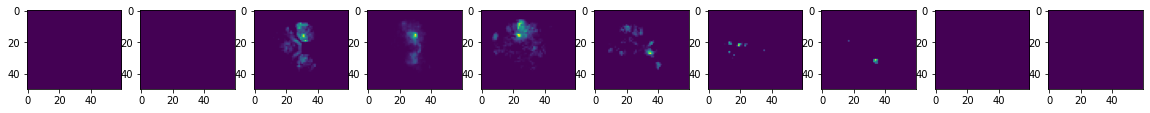

In [103]:
# encode_map = get_encode(3, "abs_norm", "results/patch3D_40_abs_norm/ae_max2/model.pth")
# encode_map = nib.load("results/patch3D_40_abs/AElin64/encode_map.nii.gz").get_fdata()
# encode_map = np.load("results/patch3D_40_z/AE3/encode_map_ave.npy")
fig, axes = plt.subplots(nrows=1, ncols=10, figsize = (20,8))
axes = axes.flat

for i, j in zip(range(0,10),range(0,50,5)):
    axes[i].imshow(encode_map[:,:,j])

# get average map

In [8]:
all_map = np.zeros((193,229,193))
for i in ['LRP', 'IG', 'GGC']:
    pth = "/home/dw/Desktop/Genie/LRP/" + i + "/All_maps/t1/modelB44/"
    for j in os.listdir(pth):
        if j.startswith("zabs"):
            niia = nib.load(pth + j).get_fdata()
            all_map += niia
all_map.shape    

(193, 229, 193)

In [10]:
all_ave = all_map/(502*3)

In [14]:
np.save("results/patch3D_40_zabs/all_map_ave/encode_map_ave",all_ave)


In [28]:
x = np.load("results/patch3D_40_zabs/all_map_ave/encode_map_ave.npy")
xb = abs(x)
print(xb.min())
np.save("results/patch3D_40_zabs/all_map_ave/encode_map_ave",xb)

0.0


In [34]:
img = nib.load("/home/dw/Desktop/tools/mni_icbm152_nlin_sym_09c/mni_icbm152_t1_tal_nlin_sym_09c_mask.nii.gz")
mask2 = img.get_fdata()
mask = [False if x == 0 else True for x in mask2.flatten()]

# colin27 = nib.load("/home/jieyoushen/Desktop/previous_work/XAI_results/meta_inMNI/Colin27_T1_seg_MNI_2x2x2.nii.gz")
# meta_small = nib.load("/home/jieyoushen/Desktop/previous_work/XAI_results/meta_inMNI/ADMCI_VBM_0_C05_100_ALE.nii")
mni = nib.load('/home/dw/Desktop/tools/mni_icbm152_nlin_sym_09c/mni_icbm152_t1_tal_nlin_sym_09c_brain.nii.gz')
meta = nib.load("/home/dw/Desktop/previous_work/XAI_results/meta_inMNI/ADMCI_VBM_noADNI_inMNI0.nii.gz")
meta_roi = nib.load("/home/dw/Desktop/previous_work/XAI_results/meta_inMNI/meta_mask/ADMCI_VBM_noADNI_0.nii.gz")

In [5]:
# encode_map = nib.load("results/patch3D_40_abs/AE/encode_mapUnseen.nii.gz")
# upsampled_nii = resample_img(encode_map, target_affine=np.eye(3)*0.25, interpolation='nearest')

def get_dice(folder_name, neg):
    encode_map = np.load("results/patch3D_40_zabs/" + folder_name + "/encode_map_ave.npy")
    upsampled_nii =encode_map
    if folder_name.startswith("AE"):
        print(folder_name)
        print(upsampled_nii.shape)
        upsampled_nii = abs(zoom(upsampled_nii, 4))
        print(upsampled_nii.shape)
        upsampled_nii = upsampled_nii[0:193,0:229,0:193]
        print(upsampled_nii.shape)

    av_ALL = abs(upsampled_nii)
    ale_ori = meta_roi.get_fdata()

    z_flat_brain = (np.array(ale_ori).flatten())[mask]
    if neg == True:
        r_flat_brain = -(np.array(av_ALL).flatten())[mask]
    else:
        r_flat_brain = (np.array(av_ALL).flatten())[mask]

    d =[]
    t =[]

    for th in np.linspace(r_flat_brain.min(), r_flat_brain.max(),50):
        r = np.where(r_flat_brain > th, 1, 0)
        tn, fp, fn, tp = confusion_matrix(r, z_flat_brain).ravel()
        dice = 2*tp / (2*tp + fp + fn)
        d.append(np.round(dice,3))
        print(np.round(dice,3),np.round(th,6))
        t.append('{:0.3e}'.format(th))
        
    return d,t


In [6]:
dAE = get_dice("AE3_128_1e-2", False)

AE3_128_1e-2
(50, 60, 50)
(200, 240, 200)
(193, 229, 193)
0.037 0.0
0.06 0.004422
0.133 0.008843
0.211 0.013265
0.277 0.017687
0.33 0.022108
0.374 0.02653
0.417 0.030951
0.456 0.035373
0.482 0.039795
0.499 0.044216
0.5 0.048638
0.494 0.05306
0.485 0.057481
0.47 0.061903
0.452 0.066324
0.434 0.070746
0.416 0.075168
0.394 0.079589
0.371 0.084011
0.35 0.088432
0.328 0.092854
0.304 0.097276
0.28 0.101697
0.257 0.106119
0.233 0.110541
0.207 0.114962
0.184 0.119384
0.159 0.123805
0.138 0.128227
0.116 0.132649
0.096 0.13707
0.08 0.141492
0.07 0.145914
0.061 0.150335
0.055 0.154757
0.048 0.159178
0.043 0.1636
0.037 0.168022
0.032 0.172443
0.028 0.176865
0.023 0.181286
0.019 0.185708
0.014 0.19013
0.011 0.194551
0.007 0.198973
0.004 0.203395
0.002 0.207816
0.001 0.212238
0.0 0.216659


In [10]:
dAEup = get_dice("AEup3_256_1e-3", False)
dAElin = get_dice("AElin64_256_1e-4", False)
dAEconc = get_dice("AEconc3_128_1e-3", False)

AEup3_256_1e-3
(50, 60, 50)
(200, 240, 200)
(193, 229, 193)
0.037 0.0
0.214 0.004336
0.311 0.008672
0.393 0.013008
0.463 0.017345
0.493 0.021681
0.481 0.026017
0.461 0.030353
0.434 0.034689
0.403 0.039025
0.371 0.043361
0.339 0.047697
0.308 0.052034
0.28 0.05637
0.256 0.060706
0.237 0.065042
0.219 0.069378
0.201 0.073714
0.184 0.07805
0.167 0.082386
0.148 0.086723
0.131 0.091059
0.113 0.095395
0.096 0.099731
0.083 0.104067
0.072 0.108403
0.063 0.112739
0.055 0.117076
0.048 0.121412
0.04 0.125748
0.035 0.130084
0.03 0.13442
0.025 0.138756
0.021 0.143092
0.018 0.147428
0.015 0.151765
0.012 0.156101
0.01 0.160437
0.008 0.164773
0.007 0.169109
0.005 0.173445
0.004 0.177781
0.003 0.182118
0.002 0.186454
0.002 0.19079
0.001 0.195126
0.001 0.199462
0.0 0.203798
0.0 0.208134
0.0 0.21247
AElin64_256_1e-4
(50, 60, 50)
(200, 240, 200)
(193, 229, 193)
0.037 0.0
0.179 0.003524
0.258 0.007048
0.32 0.010572
0.38 0.014095
0.447 0.017619
0.494 0.021143
0.502 0.024667
0.484 0.028191
0.458 0.031715
0.425

In [29]:
dAVE = get_dice("all_map_ave", False)

0.037 0.0
0.09 0.228594
0.304 0.457188
0.373 0.685782
0.416 0.914376
0.426 1.14297
0.411 1.371563
0.385 1.600157
0.349 1.828751
0.313 2.057345
0.272 2.285939
0.232 2.514533
0.195 2.743126
0.165 2.97172
0.142 3.200314
0.118 3.428908
0.099 3.657502
0.081 3.886096
0.069 4.114689
0.056 4.343283
0.046 4.571877
0.037 4.800471
0.03 5.029065
0.023 5.257659
0.018 5.486252
0.015 5.714846
0.012 5.94344
0.009 6.172034
0.007 6.400628
0.005 6.629222
0.004 6.857815
0.004 7.086409
0.003 7.315003
0.002 7.543597
0.002 7.772191
0.001 8.000784
0.001 8.229378
0.001 8.457972
0.001 8.686566
0.001 8.91516
0.001 9.143754
0.001 9.372347
0.0 9.600941
0.0 9.829535
0.0 10.058129
0.0 10.286723
0.0 10.515317
0.0 10.74391
0.0 10.972504
0.0 11.201098


In [8]:
vv =[]
for m, mod, s in zip(['LRP','IG', 'GGC'],
                     ["modelB44"]*3 , 
                     ['s0','s0','s0']):    
    data = "t1"
    method = m
    model = mod
    smooth = "s2"
    meta = "ADMCI_VBM_noADNI_0"

    with open("/home/dw/Desktop/previous_work/XAI_results/dice/" 
               + data + "_" + method + "_" + meta + "_" + model+ "_"  + smooth + ".pkl", 'rb') as f:
        v = pickle.load(f) 

    vv.append(v[s]) 

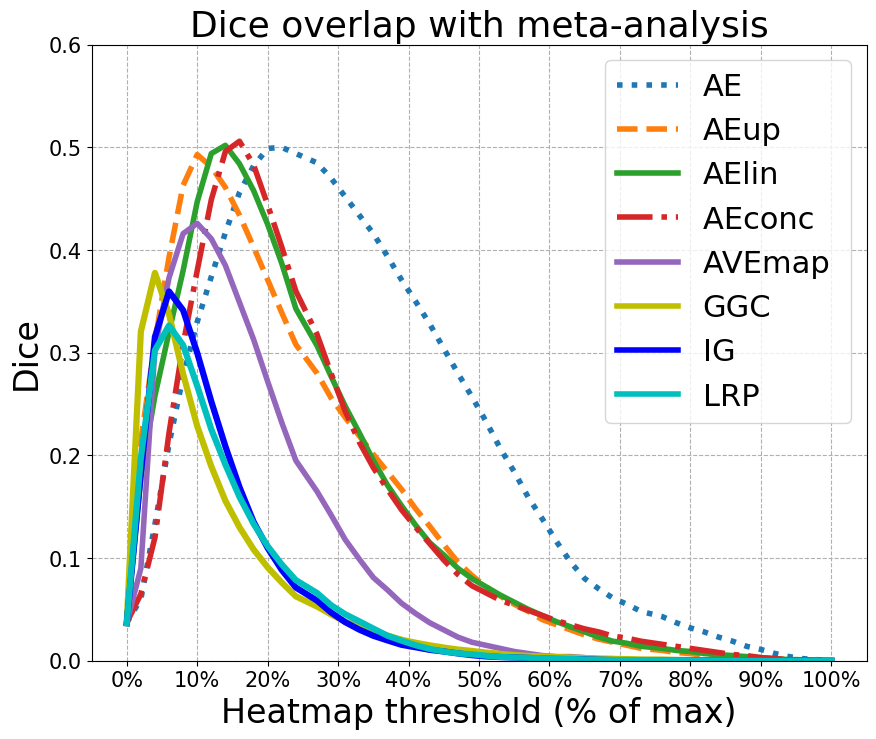

In [31]:
fig = plt.figure(figsize=(10, 8))

xx = list(np.round(np.linspace(0,1,50),2))
colors = ["c","b","y"]
plt.plot(xx,dAE[0], label = "AE",linewidth =4, linestyle = "dotted" )
plt.plot(xx,dAEup[0], label = "AEup",linewidth =4, linestyle = "dashed")
plt.plot(xx,dAElin[0], label = "AElin",linewidth =4)
plt.plot(xx,dAEconc[0], label = "AEconc ",linewidth =4, linestyle = "dashdot")

plt.plot(xx,dAVE[0], label = "AVEmap ",linewidth =4)

plt.plot(xx,vv[2][0], label= "GGC",linewidth =4.5, color = colors[2])
plt.plot(xx,vv[1][0], label= "IG",linewidth =4.5, color = colors[1])
plt.plot(xx,vv[0][0], label= "LRP",linewidth =4.5, color = colors[0])

plt.ylim(0,0.6)
plt.xlabel("Heatmap threshold (% of max)", fontsize = 24)
plt.ylabel("Dice", fontsize = 24)

# leg = plt.legend( bbox_to_anchor=(1.00, 1.03),prop={'size': 9})

plt.yticks(fontsize=15)
plt.xticks(np.arange(0, 1.1, step=0.1),fontsize=15)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values])

plt.title("Dice overlap with meta-analysis", fontsize = 26)

leg = plt.legend(prop={'size': 22})

for line in leg.get_lines():
    line.set_linewidth(4.0)  
    

plt.grid(linestyle = '--')   

In [43]:
for line in leg.get_lines():
    print(line)
#     line.set_linewidth(4.0)  

Line2D(AE)
Line2D(AEup)
Line2D(AElin)
Line2D(AEconc )
Line2D(GGC)
Line2D(IG)
Line2D(LRP)


In [16]:
my_affine = np.array([[   1.,    0.,    0.,  -96.],
                        [   0.,    1.,    0., -114.],
                        [   0.,    0.,    1.,  -96.],
                        [   0.,    0.,    0.,    1.]])

nilearn_affine = np.array([[   1.,    0.,    0.,  -98.],
                        [   0.,    1.,    0., -134.],
                        [   0.,    0.,    1.,  -72.],
                        [   0.,    0.,    0.,    1.]])

def find_th2(pth):
    th = list(np.linspace(0,1,50))
    with open(pth, 'rb') as f:
        v = pickle.load(f)

    for i in v.keys():
        n = np.max(v[i][0])
        id = v[i][0].index(n)
        print(i, np.round(n,3), v[i][1][id], id, np.round(th[id],3))
        
pth = "/home/dw/Desktop/previous_work/XAI_results/dice/t1_LRP_ADMCI_VBM_noADNI_0_modelB44_s2.pkl"
find_th2(pth)

s0 0.326 4.511e-06 3 0.061
s1 0.373 4.837e-06 5 0.102
s2 0.419 4.421e-06 7 0.143
s3 0.459 4.274e-06 9 0.184
s4 0.482 4.236e-06 11 0.224
s5 0.493 3.995e-06 12 0.245
s6 0.498 3.892e-06 13 0.265
s7 0.502 3.597e-06 13 0.265
s8 0.502 3.629e-06 14 0.286
s10 0.494 3.453e-06 15 0.306
s12 0.481 3.100e-06 15 0.306
s16 0.446 2.893e-06 17 0.347
s20 0.405 2.550e-06 18 0.367
s24 0.368 3.436e-06 29 0.592
s28 0.36 3.194e-06 32 0.653
s32 0.354 2.886e-06 34 0.694


In [32]:
print(max(dAE[0]), dAE[1][dAE[0].index(max(dAE[0]))])
print(max(dAEup[0]), dAEup[1][dAEup[0].index(max(dAEup[0]))])
print(max(dAElin[0]), dAElin[1][dAElin[0].index(max(dAElin[0]))])
print(max(dAEconc[0]), dAEconc[1][dAEconc[0].index(max(dAEconc[0]))])
print(max(dAVE[0]), dAVE[1][dAVE[0].index(max(dAVE[0]))])

0.5 4.864e-02
0.493 2.168e-02
0.502 2.467e-02
0.506 2.576e-02
0.426 1.143e+00


LRP_s0_modelB44
IG_s0_modelB44
GGC_s0_modelB44
map_ave
AE3_128_1e-2
AEup3_256_1e-3
AElin64_256_1e-4
AEconc3_128_1e-3


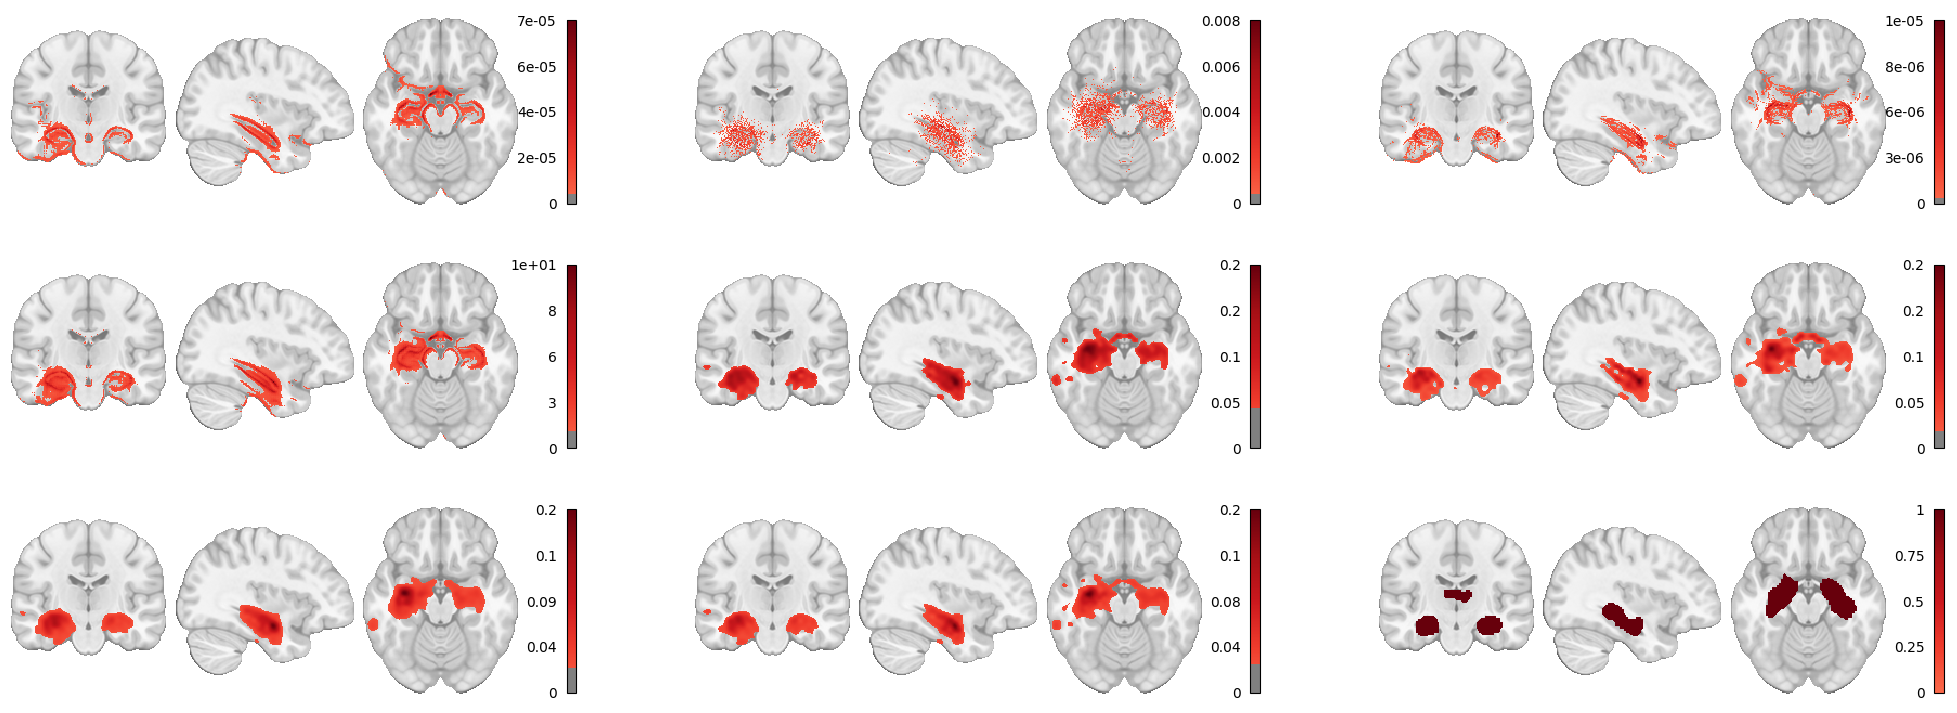

In [69]:
coord_MRI = (-48,-45, -40,-35, -30,-25,-13, 0)
best_th= [  4.511e-06        ,5.041e-04       ,4.584e-07, 1.143e+00,
          4.864e-02, 2.168e-02,  2.467e-02, 2.576e-02]
dice_smooth = ['LRP_s0_modelB44','IG_s0_modelB44', 'GGC_s0_modelB44','map_ave',
               'AE3_128_1e-2','AEup3_256_1e-3', 'AElin64_256_1e-4','AEconc3_128_1e-3']
d = [          0.326            ,0.36            ,0.378             ,0.513]

titles = ["LRP", "IG", "GGC", "map_ave","AE", "AEup", "AEconc", "AElin"]
titles = [""]*8
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 9))
axes = axes.flatten()

coor = (-35,-0,-35)

for name, th, ax, tit in zip(dice_smooth, best_th, axes, titles):
    print(name)
    mtd = name.split('_')[0]
    s = name.split('_')[1]
    model = "_".join(name.split('_')[2:])

    if name.startswith("A"):
            m = np.load("results/patch3D_40_zabs/" + name +"/encode_map_ave.npy")
            m = abs(zoom(m, 4))
            m = m[0:193,0:229,0:193]
            m = nib.Nifti1Image(m, affine = my_affine)
            plotting.plot_stat_map(m, title=tit,
                                   display_mode='ortho',
                                   cut_coords=coor,
                               cmap = "Reds",annotate=False, 
                               bg_img = mni, black_bg=False,colorbar=True,cbar_tick_format='%.1g', 
                               axes=ax, threshold= th, draw_cross = False, alpha=1)
    elif name.startswith("m"): 
        m = np.load("results/patch3D_40_zabs/all_map_ave/encode_map_ave.npy")
        m = nib.Nifti1Image(m, affine = my_affine)
        plotting.plot_stat_map(m, title=tit,
                                   display_mode='ortho',
                                   cut_coords=coor,
                               cmap = "Reds",annotate=False, 
                               bg_img = mni, black_bg=False,colorbar=True,cbar_tick_format='%.1g', 
                               axes=ax, threshold= th, draw_cross = False, alpha=1)
    else:
        m = nib.load("/home/dw/Desktop/previous_work/XAI_results/"+mtd+"/t1/modelB44/map_abs.nii")
        m = m.get_fdata()
        m = nib.Nifti1Image(m, affine = my_affine)
        plotting.plot_stat_map(m, title=tit,
                                   display_mode='ortho',
                                   cut_coords=coor,
                               cmap = "Reds",annotate=False, 
                               bg_img = mni, black_bg=False,colorbar=True,cbar_tick_format='%.1g', 
                               axes=ax, threshold= th, draw_cross = False, alpha=1)
    


meta = nib.Nifti1Image(meta_roi.get_fdata(), affine = my_affine)
plotting.plot_stat_map(meta,title=tit,cmap = "Reds",
                        display_mode='ortho',
                        cut_coords=coor,
                  threshold=0,annotate=False,colorbar=True,
                  draw_cross = False,bg_img = mni,black_bg=False,
                  figure=fig, alpha=1, axes=axes[8])


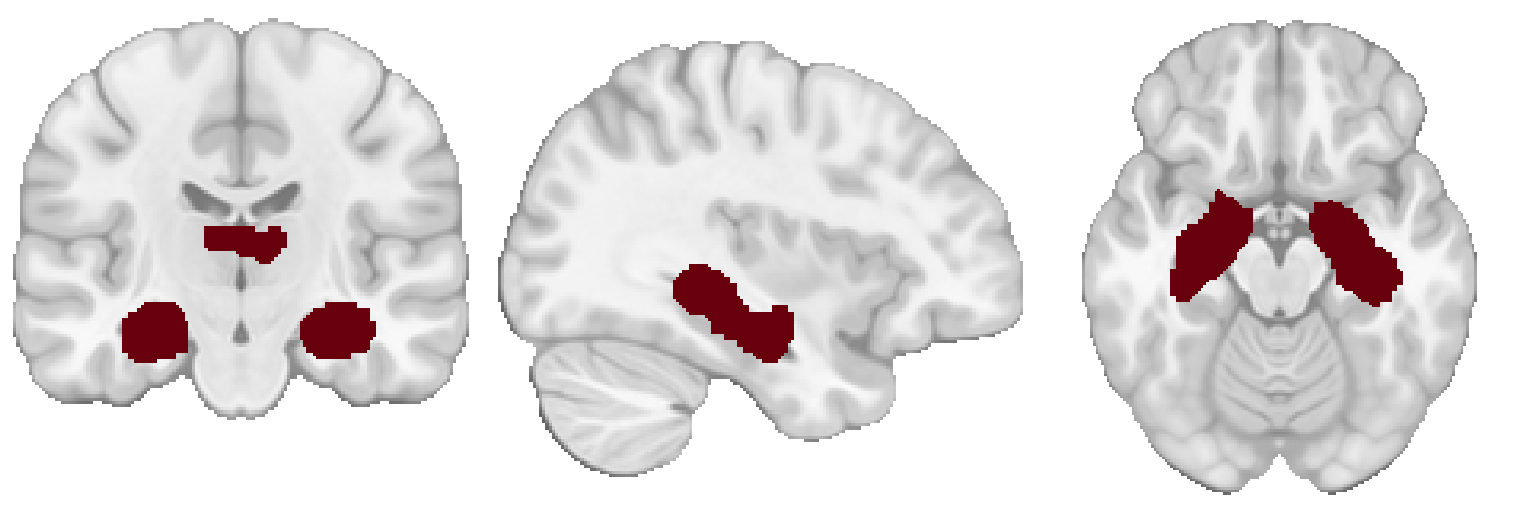

In [68]:
fig = plt.figure(figsize=(15, 5))

meta = nib.Nifti1Image(meta.get_fdata(), affine = my_affine)
plotting.plot_stat_map(meta,cmap = "Reds" ,threshold=0,annotate=False,
                  draw_cross = False,bg_img = mni,black_bg=False,
                  figure=fig, colorbar = False,
                    display_mode='ortho',
                        cut_coords=(-35,-0,-35),
                       alpha=1)